In [1]:
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [3]:
import urllib.request as u
u.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/A.png', 'test.png')
u.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/A2.png', 'test2.png')
u.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/AM.png', 'test3.png')
u.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/AM2.png', 'test4.png')
u.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/AM3.png', 'test5.png')
u.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/B.png', 'test6.png')
u.urlretrieve('https://raw.githubusercontent.com/creotiv/Python-Shape-Context/master/9.png', 'test7.png')
u.urlretrieve('https://raw.githubusercontent.com/creotiv/computer_vision/master/resources/sc/numbers.png', 'numbers.png')
u.urlretrieve('https://raw.githubusercontent.com/creotiv/computer_vision/master/resources/sc/numbers_test1.png', 'numbers_test1.png')
u.urlretrieve('https://raw.githubusercontent.com/creotiv/computer_vision/master/resources/sc/numbers_test2.png', 'numbers_test3.png')
u.urlretrieve('https://raw.githubusercontent.com/creotiv/computer_vision/master/resources/sc/numbers_test3.png', 'numbers_test3.png')

('numbers_test3.png', <http.client.HTTPMessage at 0x7fe93d586e20>)

In [2]:
import numpy as np
import cv2
import math
from scipy.spatial.distance import cdist, cosine
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt


class ShapeContext(object):

    def __init__(self, nbins_r=5, nbins_theta=12, r_inner=0.1250, r_outer=2.0):
        # number of radius zones
        self.nbins_r = nbins_r
        # number of angles zones
        self.nbins_theta = nbins_theta
        # maximum and minimum radius
        self.r_inner = r_inner
        self.r_outer = r_outer

    def _hungarian(self, cost_matrix):
        """
            Here we are solving task of getting similar points from two paths
            based on their cost matrixes. 
            This algorithm has dificulty O(n^3)
            return total modification cost, indexes of matched points
        """
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        total = cost_matrix[row_ind, col_ind].sum()
        indexes = zip(row_ind.tolist(), col_ind.tolist())
        return total, indexes

    def get_points_from_img(self, image, threshold=50, simpleto=100, radius=2):
        """
            That is not very good algorithm of choosing path points, but it will work for our case.

            Idea of it is just to create grid and choose points that on this grid.
        """
        if len(image.shape) > 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        dst = cv2.Canny(image, threshold, threshold * 3, 3)

        py, px = np.gradient(image)
        # px, py gradients maps shape can be smaller then input image shape
        points = [index for index, val in np.ndenumerate(dst)
                  if val == 255 and index[0] < py.shape[0] and index[1] < py.shape[1]]
        h, w = image.shape

        _radius = radius
        while len(points) > simpleto:
            newpoints = points
            xr = range(0, w, _radius)
            yr = range(0, h, _radius)
            for p in points:
                if p[0] not in yr and p[1] not in xr:
                    newpoints.remove(p)
                    if len(points) <= simpleto:
                        T = np.zeros((simpleto, 1))
                        for i, (y, x) in enumerate(points):
                            radians = math.atan2(py[y, x], px[y, x])
                            T[i] = radians + 2 * math.pi * (radians < 0)
                        return points, np.asmatrix(T)
            _radius += 1

        T = np.zeros((simpleto, 1))
        for i, (y, x) in enumerate(points):
            radians = math.atan2(py[y, x], px[y, x])
            T[i] = radians + 2 * math.pi * (radians < 0)

        return points, np.asmatrix(T)

    def _cost(self, hi, hj):
        cost = 0
        for k in xrange(self.nbins_theta * self.nbins_r):
            if (hi[k] + hj[k]):
                cost += ((hi[k] - hj[k])**2) / (hi[k] + hj[k])

        return cost * 0.5

    def cost_by_paper(self, P, Q, qlength=None):
        p, _ = P.shape
        p2, _ = Q.shape
        d = p2
        if qlength:
            d = qlength
        C = np.zeros((p, p2))
        for i in xrange(p):
            for j in xrange(p2):
                C[i, j] = self._cost(Q[j] / d, P[i] / p)

        return C

    def compute(self, points):
        """
          Here we are computing shape context descriptor
        """
        t_points = len(points)
        # getting euclidian distance
        r_array = cdist(points, points)
        # getting two points with maximum distance to norm angle by them
        # this is needed for rotation invariant feature
        am = r_array.argmax()
        max_points = [int(am / t_points), int(am % t_points)]
        # normalizing
        r_array_n = r_array / r_array.mean()
        # create log space
        r_bin_edges = np.logspace(np.log10(self.r_inner), np.log10(self.r_outer), self.nbins_r)
        r_array_q = np.zeros((t_points, t_points), dtype=int)
        # summing occurences in different log space intervals
        # logspace = [0.1250, 0.2500, 0.5000, 1.0000, 2.0000]
        # 0    1.3 -> 1 0 -> 2 0 -> 3 0 -> 4 0 -> 5 1
        # 0.43  0     0 1    0 2    1 3    2 4    3 5
        for m in range(self.nbins_r):
            r_array_q += (r_array_n < r_bin_edges[m])

        fz = r_array_q > 0

        # getting angles in radians
        theta_array = cdist(points, points, lambda u, v: math.atan2((v[1] - u[1]), (v[0] - u[0])))
        norm_angle = theta_array[max_points[0], max_points[1]]
        # making angles matrix rotation invariant
        theta_array = (theta_array - norm_angle * (np.ones((t_points, t_points)) - np.identity(t_points)))
        # removing all very small values because of float operation
        theta_array[np.abs(theta_array) < 1e-7] = 0

        # 2Pi shifted because we need angels in [0,2Pi]
        theta_array_2 = theta_array + 2 * math.pi * (theta_array < 0)
        # Simple Quantization
        theta_array_q = (1 + np.floor(theta_array_2 / (2 * math.pi / self.nbins_theta))).astype(int)

        # building point descriptor based on angle and distance
        nbins = self.nbins_theta * self.nbins_r
        descriptor = np.zeros((t_points, nbins))
        for i in xrange(t_points):
            sn = np.zeros((self.nbins_r, self.nbins_theta))
            for j in xrange(t_points):
                if (fz[i, j]):
                    sn[r_array_q[i, j] - 1, theta_array_q[i, j] - 1] += 1
            descriptor[i] = sn.reshape(nbins)

        return descriptor

    def cosine_diff(self, P, Q):
        """
            Fast cosine diff.
        """
        P = P.flatten()
        Q = Q.flatten()
        assert len(P) == len(Q), 'number of descriptors should be the same'
        return cosine(P, Q)

    def diff(self, P, Q, qlength=None):
        """
            More precise but not very speed efficient diff.

            if Q is generalized shape context then it compute shape match.

            if Q is r point representative shape contexts and qlength set to 
            the number of points in Q then it compute fast shape match.

        """
        result = None
        C = self.cost_by_paper(P, Q, qlength)

        result = self._hungarian(C)

        return result

    @classmethod
    def tests(cls):
        # basics tests to see that all algorithm invariants options are working fine
        self = cls()

        def test_move():
            p1 = np.array([
                [0, 100],
                [200, 60],
                [350, 220],
                [370, 100],
                [70, 300],
            ])
            # +30 by x
            p2 = np.array([
                [0, 130],
                [200, 90],
                [350, 250],
                [370, 130],
                [70, 330]
            ])
            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Moving points in 2d space should give same shape context vector"

        def test_scale():
            p1 = np.array([
                [0, 100],
                [200, 60],
                [350, 220],
                [370, 100],
                [70, 300],
            ])
            # 2x scaling
            p2 = np.array([
                [0, 200],
                [400, 120],
                [700, 440],
                [740, 200],
                [149, 600]
            ])
            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Scaling points in 2d space should give same shape context vector"

        def test_rotation():
            p1 = np.array(
                [(144, 196), (220, 216), (330, 208)]
            )
            # 90 degree rotation
            theta = np.radians(90)
            c, s = np.cos(theta), np.sin(theta)
            R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
            p2 = np.dot(p1, R).tolist()

            c1 = self.compute(p1)
            c2 = self.compute(p2)
            assert (np.abs(c1.flatten() - c2.flatten())
                    ).sum() == 0, "Rotating points in 2d space should give same shape context vector"

        test_move()
        test_scale()
        test_rotation()
        print('Tests PASSED')


ShapeContext.tests()


NameError: name 'xrange' is not defined

In [4]:
def plot(img, img2, rotate=False):
    sc = ShapeContext()
    sampls = 100

    points1,t1 = sc.get_points_from_img(img,simpleto=sampls)
    points2,t2 = sc.get_points_from_img(img2,simpleto=sampls)
    points2 = (np.array(points2)+30).tolist()

    if rotate:
        # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
        theta = np.radians(90)
        c, s = np.cos(theta), np.sin(theta)
        R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
        points2 = np.dot(np.array(points2), R).tolist()

    P = sc.compute(points1)
    print(P[0])
    x1 = [p[1] for p in points1]
    y1 = [p[0] for p in points1]
    Q = sc.compute(points2)
    x2 = [p[1] for p in points2]
    y2 = [p[0] for p in points2]

    standard_cost,indexes = sc.diff(P,Q)
    
    lines = []
    for p,q in indexes:
        lines.append(((points1[p][1],points1[p][0]), (points2[q][1],points2[q][0])))
    
    ax = plt.subplot(121)
    plt.gca().invert_yaxis()
    plt.plot(x1,y1,'go', x2,y2, 'ro')
    
    ax = plt.subplot(122)
    plt.gca().invert_yaxis()
    plt.plot(x1,y1,'go',x2,y2,'ro')
    for p1,p2 in lines:   
        plt.gca().invert_yaxis()
        plt.plot((p1[0],p2[0]),(p1[1],p2[1]), 'k-')
    plt.show()
    print("Cosine diff:", cosine(P.flatten(), Q.flatten()))
    print("Standard diff:", standard_cost)

  

Not let's see this algorithm in action with trying to match few characters.

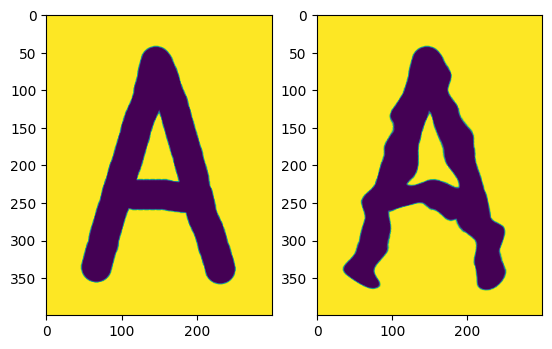

NameError: name 'xrange' is not defined

In [5]:
img = cv2.imread('test.png', 0)
img2 = cv2.imread('test3.png', 0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)

img = cv2.imread('test.png', 0)
img2 = cv2.imread('test3.png', 0)
# with 90 degree rotation
plot(img, img2, rotate=True)

img = cv2.imread('test.png', 0)
img2 = cv2.imread('test6.png', 0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()
plot(img, img2)


As you can see modification cost for shifted and rotated & shifted pathes are the same, so algorithm is trully scale & rotation invariant.

So now let's try to do something more interesting - character recognition task.

In [ ]:
sc = ShapeContext()

def get_contour_bounding_rectangles(gray):
    """
      Getting all 2nd level bouding boxes based on contour detection algorithm.
    """
    cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    res = []
    for cnt in cnts[1]:
        (x, y, w, h) = cv2.boundingRect(cnt)
        res.append((x, y, x + w, y + h))

    return res

def parse_nums(sc, path):
    img = cv2.imread(path, 0)
    # invert image colors
    img = cv2.bitwise_not(img)
    _, img = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)
    # making numbers fat for better contour detectiion
    kernel = np.ones((2, 2), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    
    # getting our numbers one by one
    rois = get_contour_bounding_rectangles(img)
    grayd = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
    nums = []
    for r in rois:
        grayd = cv2.rectangle(grayd, (r[0], r[1]), (r[2], r[3]), (0, 255, 0), 1)
        nums.append((r[0], r[1], r[2], r[3]))
    # we are getting contours in different order so we need to sort them by x1
    nums = sorted(nums, key=lambda x: x[0])
    descs = []
    for i, r in enumerate(nums):
        if img[r[1]:r[3], r[0]:r[2]].mean() < 50:
            continue
        points, _ = sc.get_points_from_img(img[r[1]:r[3], r[0]:r[2]], 50, 15)
        descriptor = sc.compute(points).flatten()
        descs.append(descriptor)
    return np.array(descs)

def match(base, current):
    """
      Here we are using cosine diff instead of "by paper" diff, cause it's faster
    """
    res = cdist(base, current.reshape((1, current.shape[0])), metric="cosine")
    char = str(np.argmin(res.reshape(11)))
    if char == '10':
        char = "/"
    return char


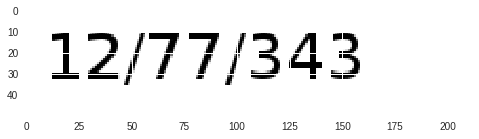

12/77/343


In [ ]:
base_0123456789 = parse_nums(sc, 'numbers.png')
recognize = parse_nums(sc, 'numbers_test3.png')
res = ""
for r in recognize:
    res += match(base_0123456789, r)

img = cv2.imread('numbers_test3.png')
plt.imshow(img)
plt.show()    
print res

**What could go wrong?**

1. One of the biggest problems of all descriptors is to choosing right key-points from image. Here we used not the best algorithm of choosing them, and in a more complex example it would fail.

2. Another thing to consider is a characters vocabluary. Here for font characters we dont need it, but if you will want to make hand written symbol recognition then you will need it, cause same symbol can be written with big difference, and only one base exmaple will fail your recognition task.

**Papers to read**


1. Main doc about shape context https://github.com/creotiv/Python-Shape-Context/blob/master/info/10.1.1.112.2716.pdf
2. Good slides for understanding mechanics of algorithm https://github.com/creotiv/Python-Shape-Context/blob/master/info/ShapeContexts425.pdf

